In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/two-sigma-connect-rental-listing-inquiries/images_sample.zip
/kaggle/input/two-sigma-connect-rental-listing-inquiries/Kaggle-renthop.torrent
/kaggle/input/two-sigma-connect-rental-listing-inquiries/sample_submission.csv.zip
/kaggle/input/two-sigma-connect-rental-listing-inquiries/test.json.zip
/kaggle/input/two-sigma-connect-rental-listing-inquiries/train.json.zip


1. 관심도가 낮은지 중간인지 높은지 분류하는 대회 
2. read_json 으로 가져오기
3. 글을 길게 적으면 사람들이 관심을 갖지 않는다고 말해주고, 사진을 올려야 관심도가 높아진다고 말해줄 수 있음 (왜 사진 너무 많이 올리면 안좋은지 생각해보기)  


# Table of Contents 
* [Baseline](#Chapter1)
    * [데이터 가져오기](#Section_1_1)
    * [photo 숫자로 바꾸기,Description길이로 바꾸기,날짜 바꾸기 ](#Section_1_2)
    * [ID drop하기](#Section_1_3)
    * [Features column 추가 컬럼 만들기](#Section_1_4)
    * [dummy 변수 처리하기](#Section_1_5)
    * [결측치 처리하기](#Section_1_6)
* [EDA](#Chapter2)
    * [Correlation 확인하기](#Section_2_0)
    * [Interest Level 분포 확인하기](#Section_2_1)
    * [날짜 변수 분포 확인하기](#Section_2_2)
* [Training](#Chapter3)
    * [Catboost](#Section_3_1)
    * [Random Forest](#Section_3_2)
----------------------
Questions

-----------------------
* [question1](#Q1)
* [question2](#Q2)
* [question3](#Q3)
* [question4](#Q4)

# 1.Baseline <a class='anchor' id='Chapter1'></a>

## 1-1.데이터 가져오기 <a class='anchor' id='Section_1_1'></a>

In [2]:
train = pd.read_json('/kaggle/input/two-sigma-connect-rental-listing-inquiries/train.json.zip')
test = pd.read_json('/kaggle/input/two-sigma-connect-rental-listing-inquiries/test.json.zip')

In [3]:
all_data = pd.concat([train,test])

In [4]:
all_data.head(15)

,bathrooms,bedrooms,building_id,created,description,display_address,features,latitude,listing_id,longitude,manager_id,photos,price,street_address,interest_level
4,1.0,1,8579a0b0d54db803821a35a4a615e97a,2016-06-16 05:55:27,Spacious 1 Bedroom 1 Bathroom in Williamsburg!...,145 Borinquen Place,"[Dining Room, Pre-War, Laundry in Building, Di...",40.7108,7170325,-73.9539,a10db4590843d78c784171a107bdacb4,[https://photos.renthop.com/2/7170325_3bb5ac84...,2400,145 Borinquen Place,medium
6,1.0,2,b8e75fc949a6cd8225b455648a951712,2016-06-01 05:44:33,BRAND NEW GUT RENOVATED TRUE 2 BEDROOMFind you...,East 44th,"[Doorman, Elevator, Laundry in Building, Dishw...",40.7513,7092344,-73.9722,955db33477af4f40004820b4aed804a0,[https://photos.renthop.com/2/7092344_7663c19a...,3800,230 East 44th,low
9,1.0,2,cd759a988b8f23924b5a2058d5ab2b49,2016-06-14 15:19:59,**FLEX 2 BEDROOM WITH FULL PRESSURIZED WALL**L...,East 56th Street,"[Doorman, Elevator, Laundry in Building, Laund...",40.7575,7158677,-73.9625,c8b10a317b766204f08e613cef4ce7a0,[https://photos.renthop.com/2/7158677_c897a134...,3495,405 East 56th Street,medium
10,1.5,3,53a5b119ba8f7b61d4e010512e0dfc85,2016-06-24 07:54:24,A Brand New 3 Bedroom 1.5 bath ApartmentEnjoy ...,Metropolitan Avenue,[],40.7145,7211212,-73.9425,5ba989232d0489da1b5f2c45f6688adc,[https://photos.renthop.com/2/7211212_1ed4542e...,3000,792 Metropolitan Avenue,medium
15,1.0,0,bfb9405149bfff42a92980b594c28234,2016-06-28 03:50:23,Over-sized Studio w abundant closets. Availabl...,East 34th Street,"[Doorman, Elevator, Fitness Center, Laundry in...",40.7439,7225292,-73.9743,2c3b41f588fbb5234d8a1e885a436cfa,[https://photos.renthop.com/2/7225292_901f1984...,2795,340 East 34th Street,low
16,1.0,3,300d27d8ba2adbcbc8c6f2bcbc1c6f9d,2016-06-28 05:59:06,This spectacular converted 3 bed apartment all...,East 16th Street,"[Doorman, Elevator, Loft, Dishwasher, Hardwood...",40.7348,7226687,-73.9865,30a7951cfc21240e8c46b2d079d292e5,[https://photos.renthop.com/2/7226687_4ea22bf1...,7200,145 East 16th Street,low
18,2.0,3,0d01cabe55fa5192cdbcabd5c585c1ea,2016-06-08 06:21:36,AMAZING DEAL!! BRAND NEW RENOVATIONS IN THIS H...,East 13th Street,"[Fireplace, Laundry in Unit, Dishwasher, Hardw...",40.7302,7126989,-73.9826,9f39caedae295bf81e67463e6fd0af40,[https://photos.renthop.com/2/7126989_a74ab3da...,6000,410 East 13th Street,low
19,1.0,0,d48767c37a934daaf0bbb0e58c755d0c,2016-06-05 05:28:22,No Fee Large Renovated Sun Splashed Studio. Wa...,York Avenue,"[Elevator, Laundry in Building, Dishwasher, Ha...",40.7769,7114138,-73.9467,9cbfa7a31ae9dfba70b4383636d99788,[https://photos.renthop.com/2/7114138_68d035c3...,1945,1661 York Avenue,high
23,0.0,1,d1ca33a2853e64fad6e4009d5d5d168f,2016-06-09 04:42:03,Extra large one bedroom apartment located in P...,E 19 Street,[Hardwood Floors],40.7346,7131094,-73.9811,b89e62bf8cdc98e9fb8b97d9bc627197,[https://photos.renthop.com/2/7131094_2117d8a9...,2435,346 E 19 Street,low
32,3.0,3,5f35dc2f0191baf109221752e6ee0c48,2016-06-28 03:26:18,Listed: 06/26/16<br /><br />Available:...,Hicks Street,"[Cats Allowed, Dogs Allowed]",40.6990,7224815,-73.9943,d5d246c9d9d4e7079e5a0fc962d2f1a7,[https://photos.renthop.com/2/7224815_8ff8a811...,6850,94 Hicks Street,low


## 1-2.photo 숫자로 바꾸기,Description길이로 바꾸기,날짜 바꾸기 <a class='anchor' id='Section_1_2'></a>

In [5]:
all_data['photos'] = all_data['photos'].apply(lambda x: len(x))

In [6]:
all_data['description'] = all_data['description'].apply(lambda x: len(str(x)))

In [7]:
all_data.head(2)

,bathrooms,bedrooms,building_id,created,description,display_address,features,latitude,listing_id,longitude,manager_id,photos,price,street_address,interest_level
4,1.0,1,8579a0b0d54db803821a35a4a615e97a,2016-06-16 05:55:27,553,145 Borinquen Place,"[Dining Room, Pre-War, Laundry in Building, Di...",40.7108,7170325,-73.9539,a10db4590843d78c784171a107bdacb4,12,2400,145 Borinquen Place,medium
6,1.0,2,b8e75fc949a6cd8225b455648a951712,2016-06-01 05:44:33,827,East 44th,"[Doorman, Elevator, Laundry in Building, Dishw...",40.7513,7092344,-73.9722,955db33477af4f40004820b4aed804a0,6,3800,230 East 44th,low


In [8]:
all_data['created'] = pd.to_datetime(all_data['created'])
all_data['year'] = all_data['created'].dt.year
all_data['month'] = all_data['created'].dt.month
all_data['day'] = all_data['created'].dt.day
all_data['hour'] = all_data['created'].dt.hour

In [9]:
all_data.head(2)

,bathrooms,bedrooms,building_id,created,description,display_address,features,latitude,listing_id,longitude,manager_id,photos,price,street_address,interest_level,year,month,day,hour
4,1.0,1,8579a0b0d54db803821a35a4a615e97a,2016-06-16 05:55:27,553,145 Borinquen Place,"[Dining Room, Pre-War, Laundry in Building, Di...",40.7108,7170325,-73.9539,a10db4590843d78c784171a107bdacb4,12,2400,145 Borinquen Place,medium,2016,6,16,5
6,1.0,2,b8e75fc949a6cd8225b455648a951712,2016-06-01 05:44:33,827,East 44th,"[Doorman, Elevator, Laundry in Building, Dishw...",40.7513,7092344,-73.9722,955db33477af4f40004820b4aed804a0,6,3800,230 East 44th,low,2016,6,1,5


## 1-3.ID drop하기 <a class='anchor' id='Section_1_3'></a>

In [10]:
all_data = all_data.drop(columns=['building_id','manager_id'])

In [11]:
all_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 124011 entries, 4 to 124010
Data columns (total 17 columns):
 #   Column           Non-Null Count   Dtype         
---  ------           --------------   -----         
 0   bathrooms        124011 non-null  float64       
 1   bedrooms         124011 non-null  int64         
 2   created          124011 non-null  datetime64[ns]
 3   description      124011 non-null  int64         
 4   display_address  124011 non-null  object        
 5   features         124011 non-null  object        
 6   latitude         124011 non-null  float64       
 7   listing_id       124011 non-null  int64         
 8   longitude        124011 non-null  float64       
 9   photos           124011 non-null  int64         
 10  price            124011 non-null  int64         
 11  street_address   124011 non-null  object        
 12  interest_level   49352 non-null   object        
 13  year             124011 non-null  int64         
 14  month            124

## 1-4.Features column 추가 컬럼 만들기 <a class='anchor' id='Section_1_4'></a>

In [12]:
all_data['features'] = all_data['features'].apply(lambda x: list(x))

In [13]:
type(all_data['features'][0])
all_data['features_num'] = all_data['features'].apply(lambda x: len(x))
all_data

,bathrooms,bedrooms,created,description,display_address,features,latitude,listing_id,longitude,photos,price,street_address,interest_level,year,month,day,hour,features_num
4,1.0,1,2016-06-16 05:55:27,553,145 Borinquen Place,"[Dining Room, Pre-War, Laundry in Building, Di...",40.7108,7170325,-73.9539,12,2400,145 Borinquen Place,medium,2016,6,16,5,7
6,1.0,2,2016-06-01 05:44:33,827,East 44th,"[Doorman, Elevator, Laundry in Building, Dishw...",40.7513,7092344,-73.9722,6,3800,230 East 44th,low,2016,6,1,5,6
9,1.0,2,2016-06-14 15:19:59,799,East 56th Street,"[Doorman, Elevator, Laundry in Building, Laund...",40.7575,7158677,-73.9625,6,3495,405 East 56th Street,medium,2016,6,14,15,6
10,1.5,3,2016-06-24 07:54:24,588,Metropolitan Avenue,[],40.7145,7211212,-73.9425,5,3000,792 Metropolitan Avenue,medium,2016,6,24,7,0
15,1.0,0,2016-06-28 03:50:23,344,East 34th Street,"[Doorman, Elevator, Fitness Center, Laundry in...",40.7439,7225292,-73.9743,4,2795,340 East 34th Street,low,2016,6,28,3,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
124003,1.0,1,2016-04-26 16:09:55,258,150 EAST 107TH STREET,[],40.7925,6928108,-73.9454,10,1700,158 EAST 107TH STREET,NaN,2016,4,26,16,0
124005,1.0,2,2016-04-21 05:06:19,701,E 33rd St.,"[Doorman, Elevator, Laundry in Building, Dishw...",40.7456,6906674,-73.9797,4,4195,141 E 33rd St.,NaN,2016,4,21,5,8
124006,1.0,0,2016-04-20 01:31:52,866,Lexington Avenue,"[Dogs Allowed, Cats Allowed]",40.7416,6897967,-73.9829,0,2400,95 Lexington Avenue,NaN,2016,4,20,1,2
124007,2.0,2,2016-04-08 02:26:45,816,Park Avenue,"[Doorman, Elevator, Cats Allowed, Dogs Allowed]",40.7485,6842183,-73.9800,8,6895,41 Park Avenue,NaN,2016,4,8,2,4


## 1-5.dummy 변수 처리하기 <a class='anchor' id='Section_1_5'></a>
질문1. 만약에 Catboost 쓰려면 더미 처리해야하는데 왜 안되지 ? ㅠㅠ <a class='anchor' id='Q1'></a>

In [14]:
#all_data = pd.get_dummies(all_data)

In [15]:
#all_data = pd.get_dummies(all_data)

## 1-6.결측치 처리하기 <a class='anchor' id='Section_1_6'></a>

In [16]:
all_data.isnull().sum()

bathrooms              0
bedrooms               0
created                0
description            0
display_address        0
features               0
latitude               0
listing_id             0
longitude              0
photos                 0
price                  0
street_address         0
interest_level     74659
year                   0
month                  0
day                    0
hour                   0
features_num           0
dtype: int64

# 2.EDA <a class='anchor' id='Chapter2'></a>

## 2-0.Correlation 확인하기 <a class='anchor' id='Section_2_0'></a>

In [17]:
group = all_data.groupby(all_data['interest_level']).mean()
group

,bathrooms,bedrooms,description,latitude,listing_id,longitude,photos,price,year,month,day,hour,features_num
interest_level,,,,,,,,,,,,,
high,1.116176,1.546496,608.265434,40.748007,7.017844e+06,-73.964613,5.738474,2700.293045,2016.0,5.014848,14.344621,6.444647,5.158635
low,1.238741,1.514759,584.444551,40.739504,7.026373e+06,-73.951667,5.524647,4176.599142,2016.0,5.018697,15.384465,4.331029,5.307957
medium,1.163906,1.622050,653.350521,40.745567,7.019098e+06,-73.965033,5.813251,3158.767388,2016.0,5.003117,14.959480,5.514382,5.888681


## 2-1.Interest Level 분포 확인하기 <a class='anchor' id='Section_2_1'></a>

In [18]:
import seaborn as sns
import matplotlib.pyplot as plt

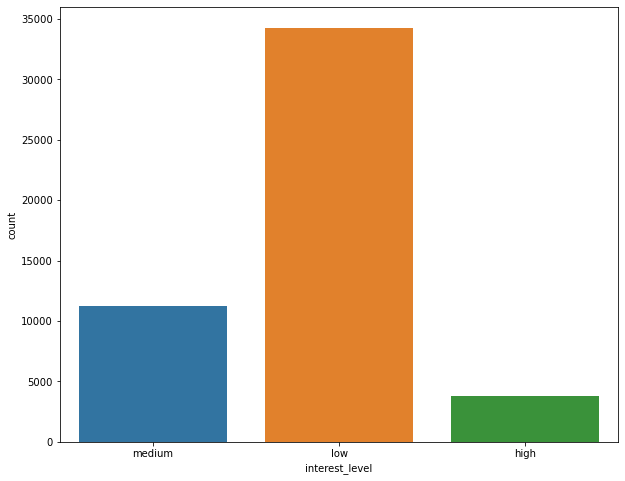

In [19]:
plt.figure(figsize=(10,8))
sns.countplot(all_data['interest_level'])

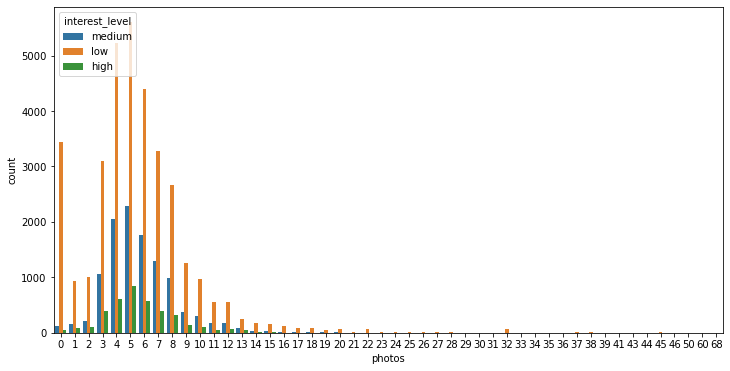

In [20]:
plt.figure(figsize=(12,6))
sns.countplot(all_data['photos'],hue=all_data['interest_level'])

### 사진의 수는 4,5,6개가 가장 많고, 사진 갯수가 12개부터는 부정적인 영향을 줌

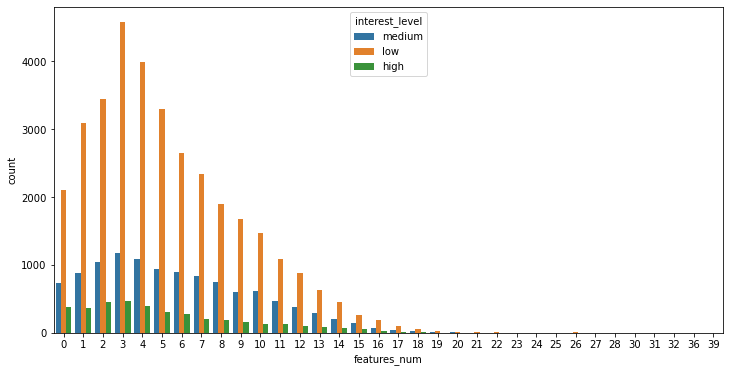

In [21]:
plt.figure(figsize=(12,6))
sns.countplot(all_data['features_num'],hue=all_data['interest_level'])

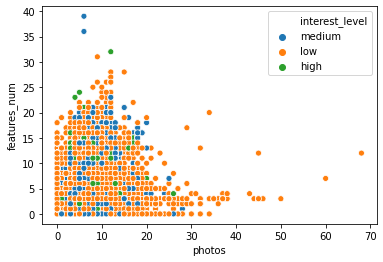

In [22]:
sns.scatterplot(data=all_data, x="photos", y="features_num", hue="interest_level")

<Figure size 864x1440 with 0 Axes>

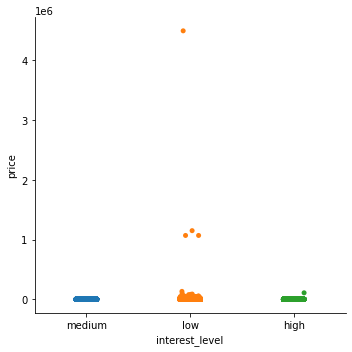

In [23]:
plt.figure(figsize=(12,20))
sns.catplot(x='interest_level',y='price', data=all_data)

### 가격이 너무 높을 경우 interst level이 낮음

## 2-2.날짜 변수 분포 확인하기<a class='anchor' id='Section_2_2'></a>

질문: for 문으로 2x2 그래프 그리기 <a class='anchor' id='Q2'></a>

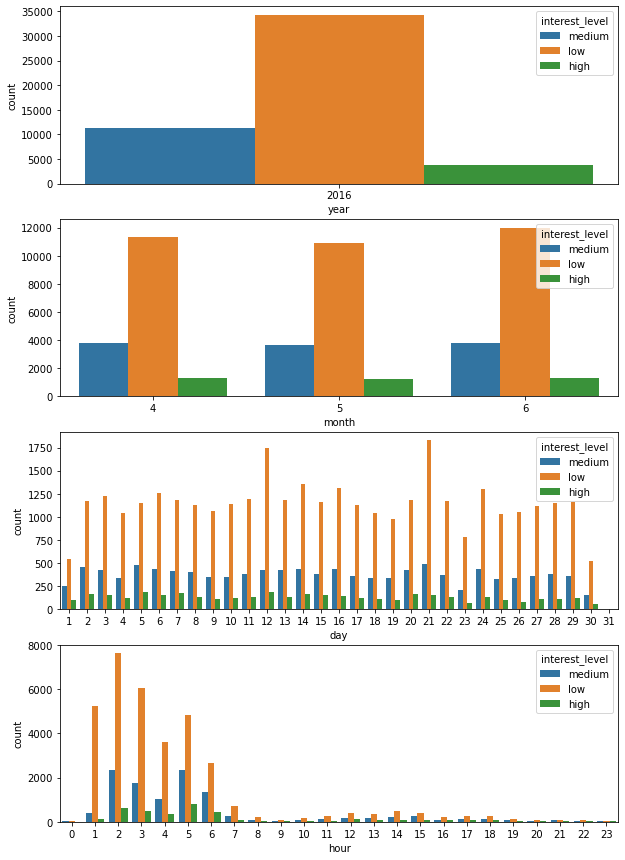

In [24]:
_ , b = plt.subplots(4, 1, figsize=(10,15))

for i, item in enumerate(['year','month','day','hour']):
    sns.countplot(all_data[item], hue=all_data['interest_level'], ax=b[i])
            

# sns.countplot(all_data['year'],hue=all_data['interest_level'],ax=b[0][0])
# sns.countplot(all_data['month'],hue=all_data['interest_level'],ax=b[0][1])
# sns.countplot(all_data['day'],hue=all_data['interest_level'],ax=b[1][0])
# sns.countplot(all_data['hour'],hue=all_data['interest_level'],ax=b[1][1])

### *hour이 정말 중요한 변수라는 걸 알 수 있음 

# 3. Training <a class='anchor' id='Chapter3'></a>
 
질문: Catboost랑 randomforest 장단점 -> Catboost가 더 튜닝 다양하게 가능하고, 더 많은 컬럼에 유리하면 언제나 Catboost가 Better? <a class='anchor' id='Q3'></a>

In [25]:
all_data

,bathrooms,bedrooms,created,description,display_address,features,latitude,listing_id,longitude,photos,price,street_address,interest_level,year,month,day,hour,features_num
4,1.0,1,2016-06-16 05:55:27,553,145 Borinquen Place,"[Dining Room, Pre-War, Laundry in Building, Di...",40.7108,7170325,-73.9539,12,2400,145 Borinquen Place,medium,2016,6,16,5,7
6,1.0,2,2016-06-01 05:44:33,827,East 44th,"[Doorman, Elevator, Laundry in Building, Dishw...",40.7513,7092344,-73.9722,6,3800,230 East 44th,low,2016,6,1,5,6
9,1.0,2,2016-06-14 15:19:59,799,East 56th Street,"[Doorman, Elevator, Laundry in Building, Laund...",40.7575,7158677,-73.9625,6,3495,405 East 56th Street,medium,2016,6,14,15,6
10,1.5,3,2016-06-24 07:54:24,588,Metropolitan Avenue,[],40.7145,7211212,-73.9425,5,3000,792 Metropolitan Avenue,medium,2016,6,24,7,0
15,1.0,0,2016-06-28 03:50:23,344,East 34th Street,"[Doorman, Elevator, Fitness Center, Laundry in...",40.7439,7225292,-73.9743,4,2795,340 East 34th Street,low,2016,6,28,3,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
124003,1.0,1,2016-04-26 16:09:55,258,150 EAST 107TH STREET,[],40.7925,6928108,-73.9454,10,1700,158 EAST 107TH STREET,NaN,2016,4,26,16,0
124005,1.0,2,2016-04-21 05:06:19,701,E 33rd St.,"[Doorman, Elevator, Laundry in Building, Dishw...",40.7456,6906674,-73.9797,4,4195,141 E 33rd St.,NaN,2016,4,21,5,8
124006,1.0,0,2016-04-20 01:31:52,866,Lexington Avenue,"[Dogs Allowed, Cats Allowed]",40.7416,6897967,-73.9829,0,2400,95 Lexington Avenue,NaN,2016,4,20,1,2
124007,2.0,2,2016-04-08 02:26:45,816,Park Avenue,"[Doorman, Elevator, Cats Allowed, Dogs Allowed]",40.7485,6842183,-73.9800,8,6895,41 Park Avenue,NaN,2016,4,8,2,4


In [26]:
all_data2 = all_data.drop(columns=['interest_level','created','features','street_address','display_address'])

In [27]:
all_data = all_data.fillna(-1)

In [28]:
train2 = all_data2[:len(train)]
target2 = all_data[:len(train)]['interest_level']
display(train2, target2, target2.isnull().sum())

,bathrooms,bedrooms,description,latitude,listing_id,longitude,photos,price,year,month,day,hour,features_num
4,1.0,1,553,40.7108,7170325,-73.9539,12,2400,2016,6,16,5,7
6,1.0,2,827,40.7513,7092344,-73.9722,6,3800,2016,6,1,5,6
9,1.0,2,799,40.7575,7158677,-73.9625,6,3495,2016,6,14,15,6
10,1.5,3,588,40.7145,7211212,-73.9425,5,3000,2016,6,24,7,0
15,1.0,0,344,40.7439,7225292,-73.9743,4,2795,2016,6,28,3,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...
124000,1.0,3,852,40.8433,6824800,-73.9396,5,2800,2016,4,5,3,3
124002,1.0,2,552,40.8198,6813268,-73.9578,5,2395,2016,4,2,2,7
124004,1.0,1,550,40.5765,6927093,-73.9554,3,1850,2016,4,26,5,11
124008,1.0,2,845,40.7448,6892816,-74.0017,5,4195,2016,4,19,2,5


4         medium
6            low
9         medium
10        medium
15           low
           ...  
124000       low
124002    medium
124004    medium
124008    medium
124009      high
Name: interest_level, Length: 49352, dtype: object

0

## 3-1.Catboost <a class='anchor' id='Section_3_1'></a>

In [29]:
all_data['interest_level'].describe()

count     124011
unique         4
top           -1
freq       74659
Name: interest_level, dtype: int64

In [30]:
from sklearn.model_selection import train_test_split 
X_train, X_valid, Y_train, Y_valid = train_test_split(train2, all_data[:len(train)]['interest_level'], test_size=0.2, random_state=123)


In [31]:
from catboost import CatBoostClassifier 
cbc = CatBoostClassifier(task_type='GPU')
cbc.fit(X_train, Y_train, eval_set=(X_valid, Y_valid))
result=cbc.predict_proba(X_valid)
result


Learning rate set to 0.152429
0:	learn: 0.9933619	test: 0.9937998	best: 0.9937998 (0)	total: 39.6ms	remaining: 39.6s
1:	learn: 0.9211204	test: 0.9217522	best: 0.9217522 (1)	total: 60.6ms	remaining: 30.3s
2:	learn: 0.8688690	test: 0.8695839	best: 0.8695839 (2)	total: 76.8ms	remaining: 25.5s
3:	learn: 0.8285803	test: 0.8296436	best: 0.8296436 (3)	total: 101ms	remaining: 25.3s
4:	learn: 0.7955591	test: 0.7971724	best: 0.7971724 (4)	total: 117ms	remaining: 23.4s
5:	learn: 0.7717479	test: 0.7735345	best: 0.7735345 (5)	total: 134ms	remaining: 22.2s
6:	learn: 0.7509345	test: 0.7531300	best: 0.7531300 (6)	total: 149ms	remaining: 21.2s
7:	learn: 0.7353694	test: 0.7383111	best: 0.7383111 (7)	total: 167ms	remaining: 20.7s
8:	learn: 0.7216474	test: 0.7255047	best: 0.7255047 (8)	total: 184ms	remaining: 20.2s
9:	learn: 0.7108728	test: 0.7153010	best: 0.7153010 (9)	total: 199ms	remaining: 19.7s
10:	learn: 0.7010672	test: 0.7056038	best: 0.7056038 (10)	total: 215ms	remaining: 19.3s
11:	learn: 0.693000

array([[0.00503019, 0.81929281, 0.175677  ],
       [0.00404833, 0.96867784, 0.02727383],
       [0.06827468, 0.62387785, 0.30784747],
       ...,
       [0.00474918, 0.90967699, 0.08557384],
       [0.02286331, 0.67834585, 0.29879084],
       [0.32342476, 0.26095365, 0.41562159]])

질문: 왜 안되지? 두 개 모델 다 <a class='anchor' id='Q4'></a>

## 3-2.Random Forest<a class='anchor' id='Section_3_2'></a>

질문: 여기에 category '-1'은 빠졌는지 어뜨케 앎? predict 중에서.. <a class='anchor' id='Q5'></a>

In [32]:
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(n_estimators=100,n_jobs=-1, random_state=12)
rf.fit(train2, target2)
result = rf.predict_proba(all_data2[len(train):])

In [33]:
result

array([[0.08, 0.5 , 0.42],
       [0.33, 0.33, 0.34],
       [0.03, 0.94, 0.03],
       ...,
       [0.  , 0.99, 0.01],
       [0.  , 0.96, 0.04],
       [0.07, 0.77, 0.16]])

In [34]:
sub = pd.read_csv('/kaggle/input/two-sigma-connect-rental-listing-inquiries/sample_submission.csv.zip')

In [35]:
sub

,listing_id,high,medium,low
0,7142618,0.077788,0.227529,0.694683
1,7210040,0.077788,0.227529,0.694683
2,7174566,0.077788,0.227529,0.694683
3,7191391,0.077788,0.227529,0.694683
4,7171695,0.077788,0.227529,0.694683
...,...,...,...,...
74654,6928108,0.077788,0.227529,0.694683
74655,6906674,0.077788,0.227529,0.694683
74656,6897967,0.077788,0.227529,0.694683
74657,6842183,0.077788,0.227529,0.694683


In [36]:
sub['high'] = result[:,0]
sub['medium'] = result[:,1]
sub['low'] = result[:,2]

In [37]:
sub

,listing_id,high,medium,low
0,7142618,0.08,0.50,0.42
1,7210040,0.33,0.33,0.34
2,7174566,0.03,0.94,0.03
3,7191391,0.29,0.34,0.37
4,7171695,0.00,0.79,0.21
...,...,...,...,...
74654,6928108,0.33,0.32,0.35
74655,6906674,0.08,0.75,0.17
74656,6897967,0.00,0.99,0.01
74657,6842183,0.00,0.96,0.04


In [38]:
sub.to_csv('submission.csv')